# Set-Up

In [135]:
%run Set_Up.ipynb

# 4-step algorithm

In [136]:
%run algorithm_4_steps.ipynb

## Plotting gradients of 8 countries

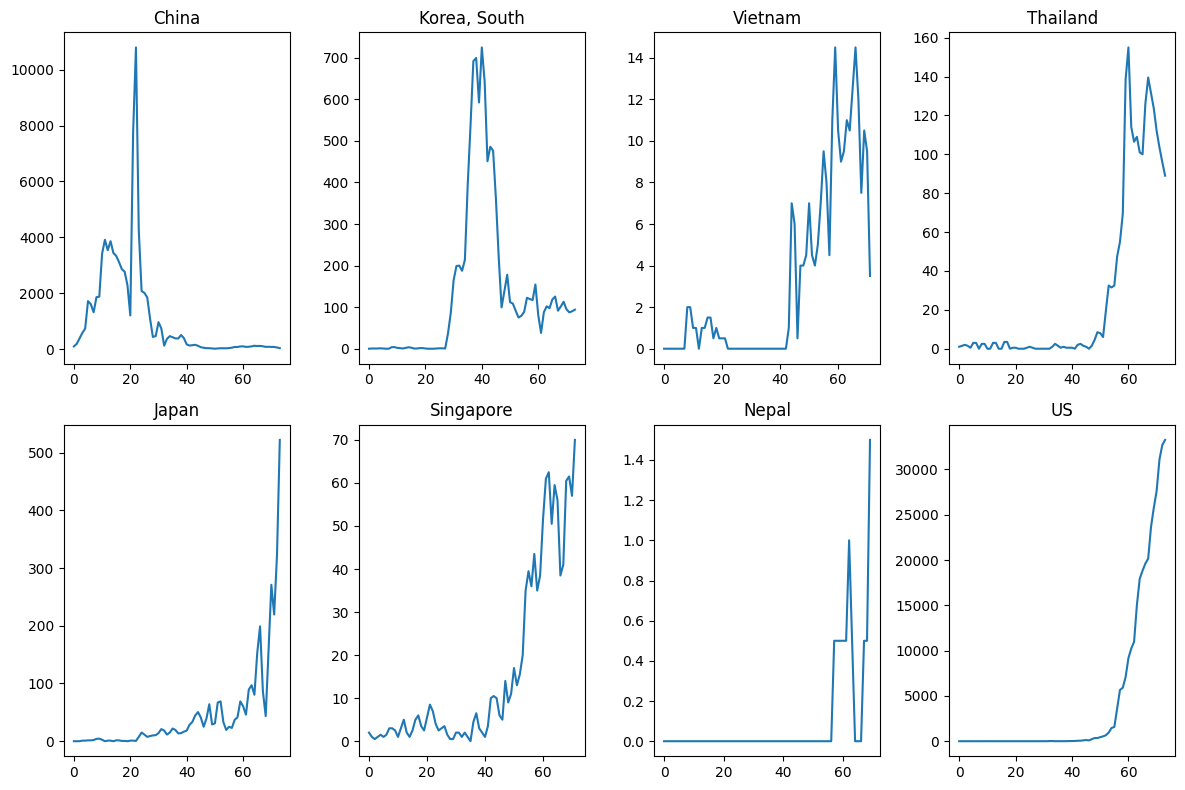

In [137]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

prova = data_1day[['China', 'Korea, South', 'Vietnam', 'Thailand', 'Japan', 'Singapore', 'Nepal', 'US']]
for i, country in enumerate(prova.columns):
    ax = axes.flat[i]
    ax.plot(np.gradient(data_1day[country]))
    ax.set_title(country)

# Show the plot
plt.tight_layout()
plt.show()


# Visualizations (Cases per Day)
## Choose relevant columns - truncating data

In [138]:
# TODO Add titles and axis labels to all visualisations 
def truncate_date(data_date):
    last_day = data_date.loc['04/04/2020']
    last_day = last_day.sort_values(ascending=False)
    last_day_high = last_day[:30]
    last_day_low = last_day[-30:]
    data_high = data_date[last_day_high.index]
    data_low = data_date[last_day_low.index]
    return data_high, data_low

def truncate_day(data_day, data_date):
    data_day = data_day.copy()
    columns = list(set(data_day.columns) & set(data_date.columns))
    first_occ = data_date[columns] > 0 
    first_occ = first_occ.apply(pd.Series.idxmax)
    first_occ = first_occ.sort_values(ascending = True)
    first_occ_high = first_occ[:30]
    first_occ_low = first_occ[-30:]
    data_high = data_day[first_occ_high.index] 
    data_low = data_date[first_occ_low.index]
    return data_high, data_low

data_1date_trunc, data_1date_low = truncate_date(data_1date) 
data_2date_trunc, data_2date_low = truncate_date(data_2date)
data_5date_trunc, data_5date_low = truncate_date(data_5date)
data_1day_trunc, data_1day_low = truncate_day(data_1day, data_1date)   
data_2day_trunc, data_2day_low = truncate_day(data_2day, data_2date)
data_5day_trunc, data_5day_low = truncate_day(data_5day, data_5date)

## Plot Cases

### Absolute cases

#### Highest cases

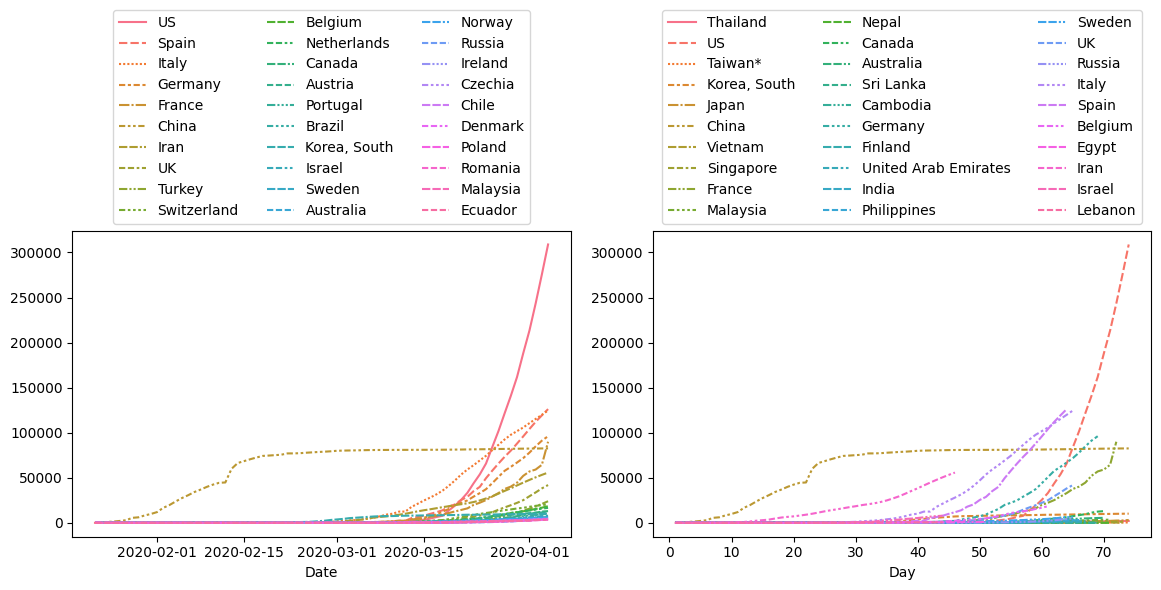

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_1date_trunc, ax=ax1)
sns.lineplot(data=data_1day_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()


#### Lowest cases

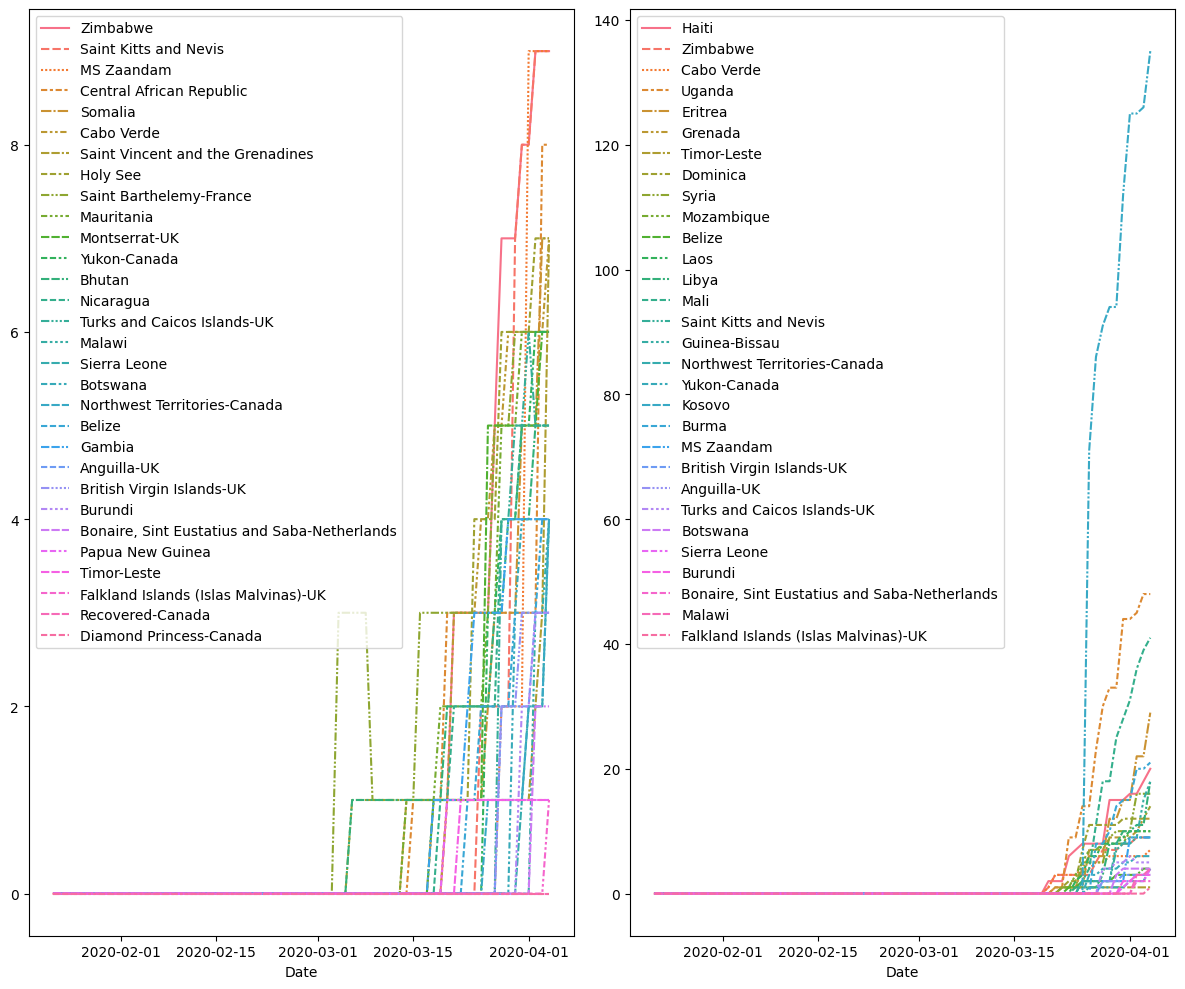

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_1date_low, ax=ax1)
sns.lineplot(data=data_1day_low, ax=ax2)

plt.tight_layout()
plt.show()

### Cases per 1 million

#### Highest cases

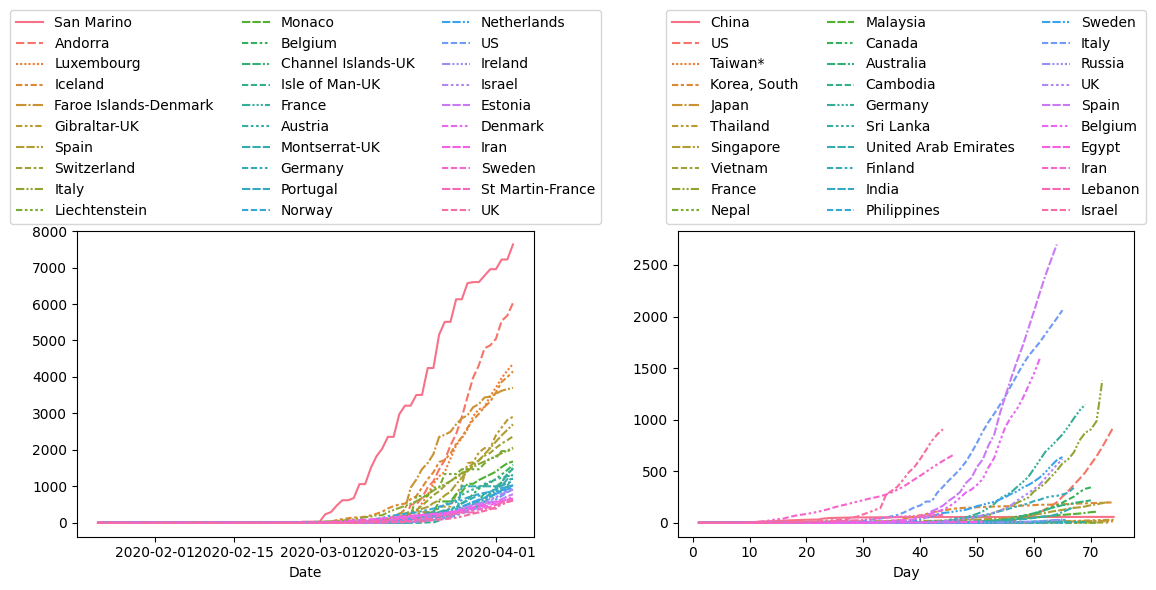

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_2date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_2day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()
#TODO fix positions and number of columns legend

#### Lowest cases

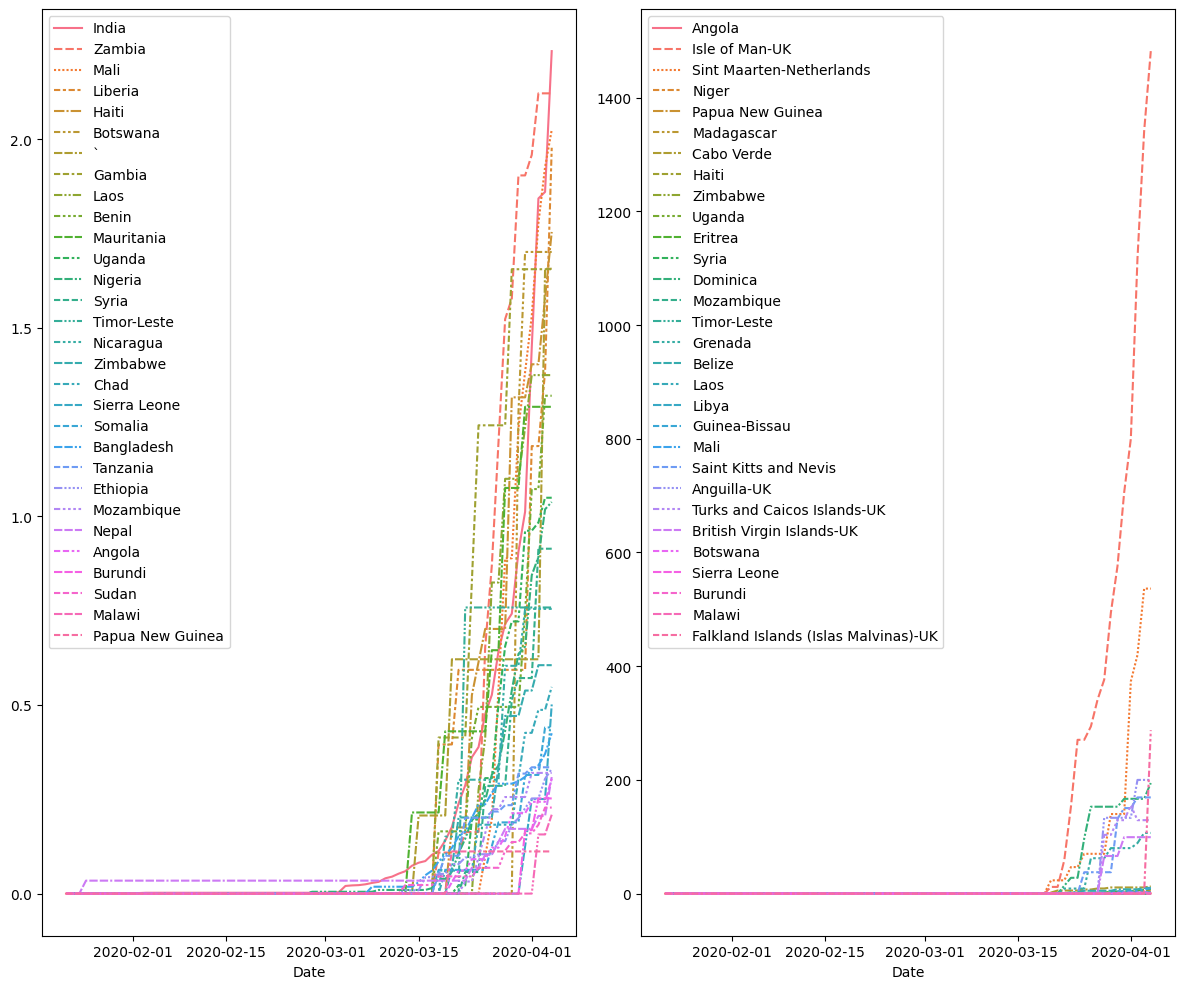

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_2date_low, ax=ax1)
sns.lineplot(data=data_2day_low, ax=ax2)

plt.tight_layout()
plt.show()

### Cases per population per land

#### Highest cases

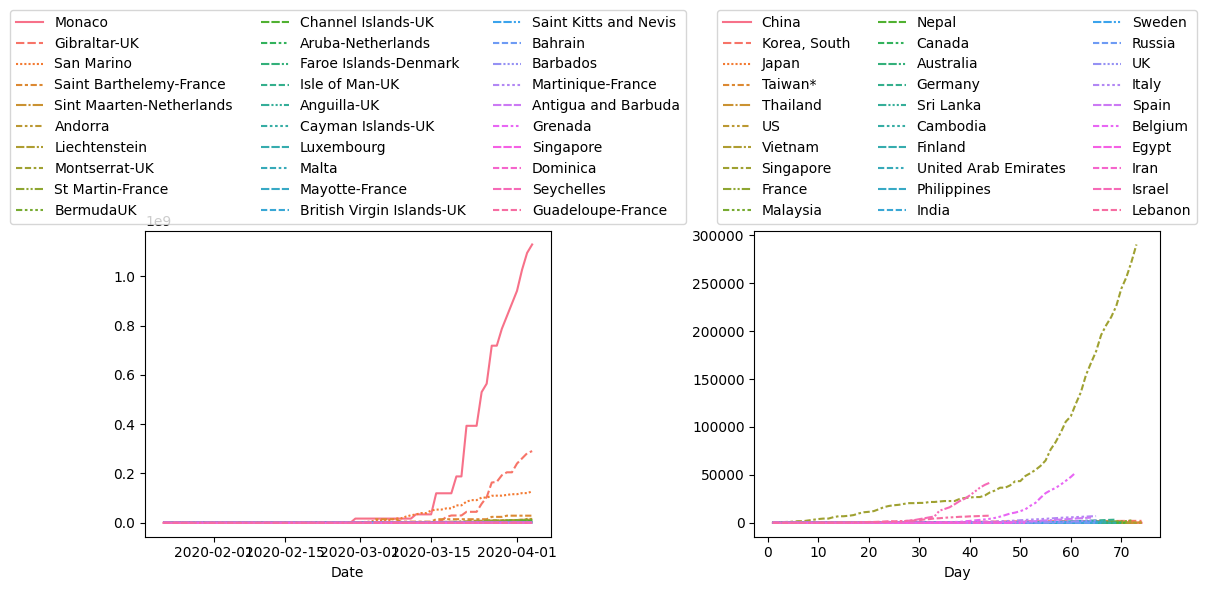

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=data_5date_trunc, ax=ax1)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

sns.lineplot(data=data_5day_trunc, ax=ax2)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol= 3, fancybox=True)

plt.tight_layout()
plt.show()

#### Lowest cases

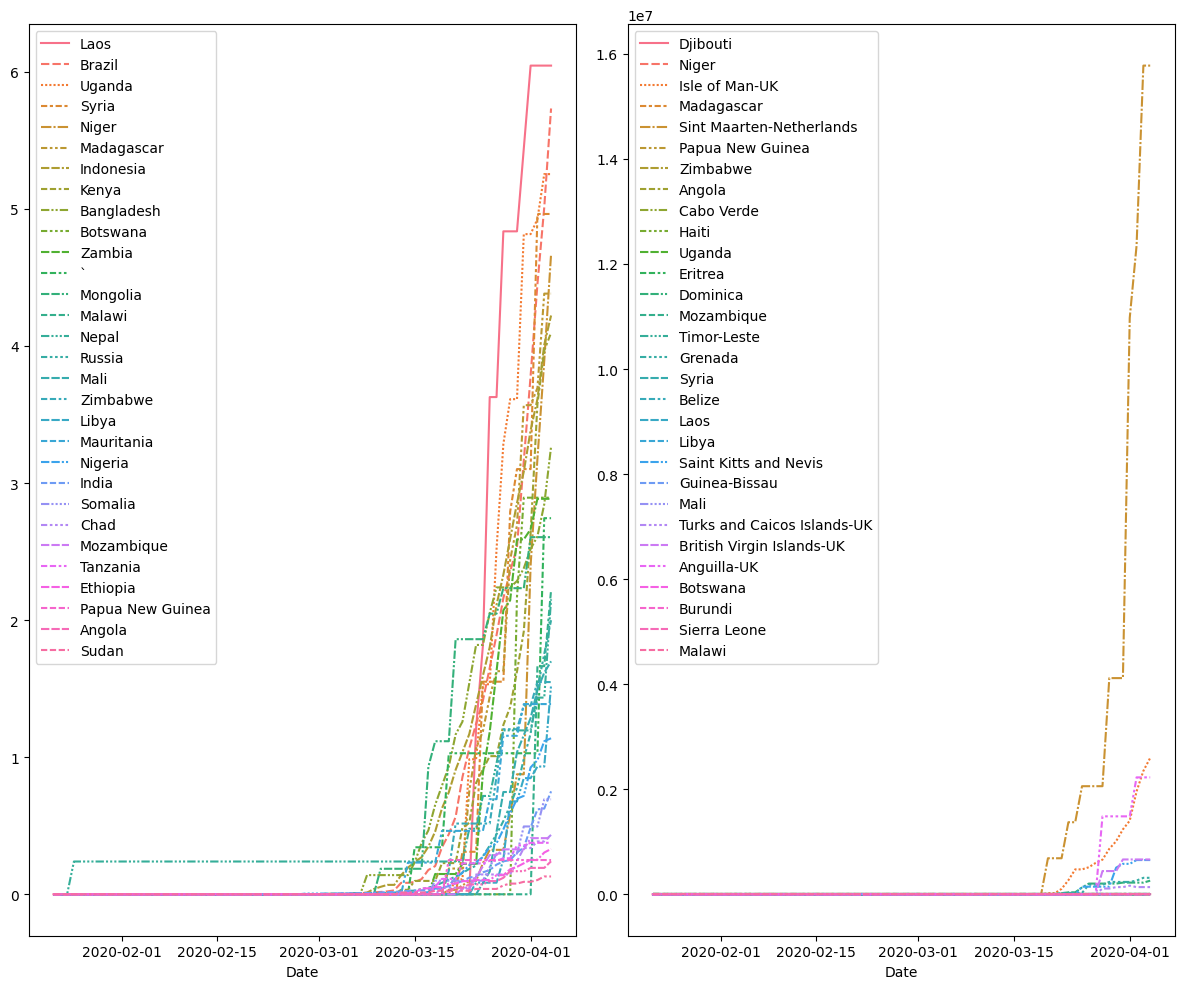

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_5date_low, ax=ax1)
sns.lineplot(data=data_5day_low, ax=ax2)

plt.tight_layout()
plt.show()

# Agglomerative Clustering

In [145]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [146]:
#TODO Only use one color instead of many for clustering visualisations - or should we leave it like this? 
# TODO Check why there are differents in clustering for our clustering and the paper (e.g. Fig. 6 has San Marino separated, we not)
def plot_hierarchy(data, ax, complete=False):
    data = data.transpose()
    if not complete:
        linkage_matrix = linkage(data, method='single', metric='euclidean')
    else:
        linkage_matrix = linkage(data, method='complete', metric='euclidean')
    
    country_names = data.index.to_list()

    def llf(i):
        return '{}---{}'.format(country_names[i], i)

    R = dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
        , count_sort=True
    )
    ax.set_xticks([])
    return R

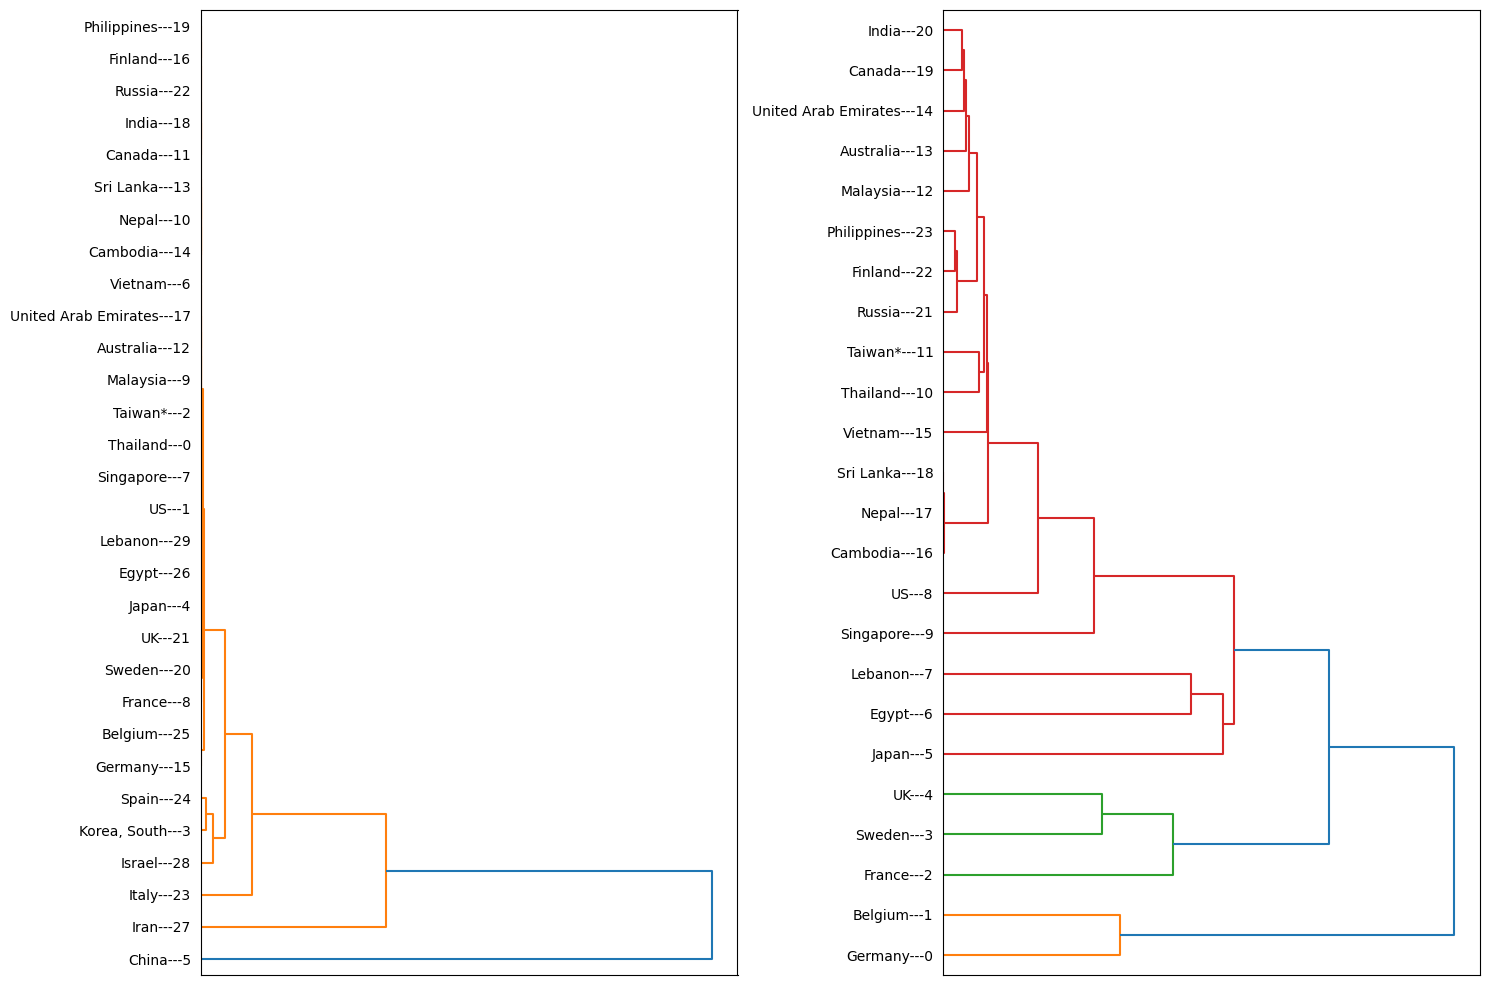

In [147]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

dend1 = plot_hierarchy(data_1day_trunc[:44], ax=axes[0], complete=True)
plot_hierarchy(data_1day_trunc.iloc[:44, dend1['leaves'][6:]], ax=axes[1])

fig.tight_layout()

plt.savefig('../figures/Clustering1')

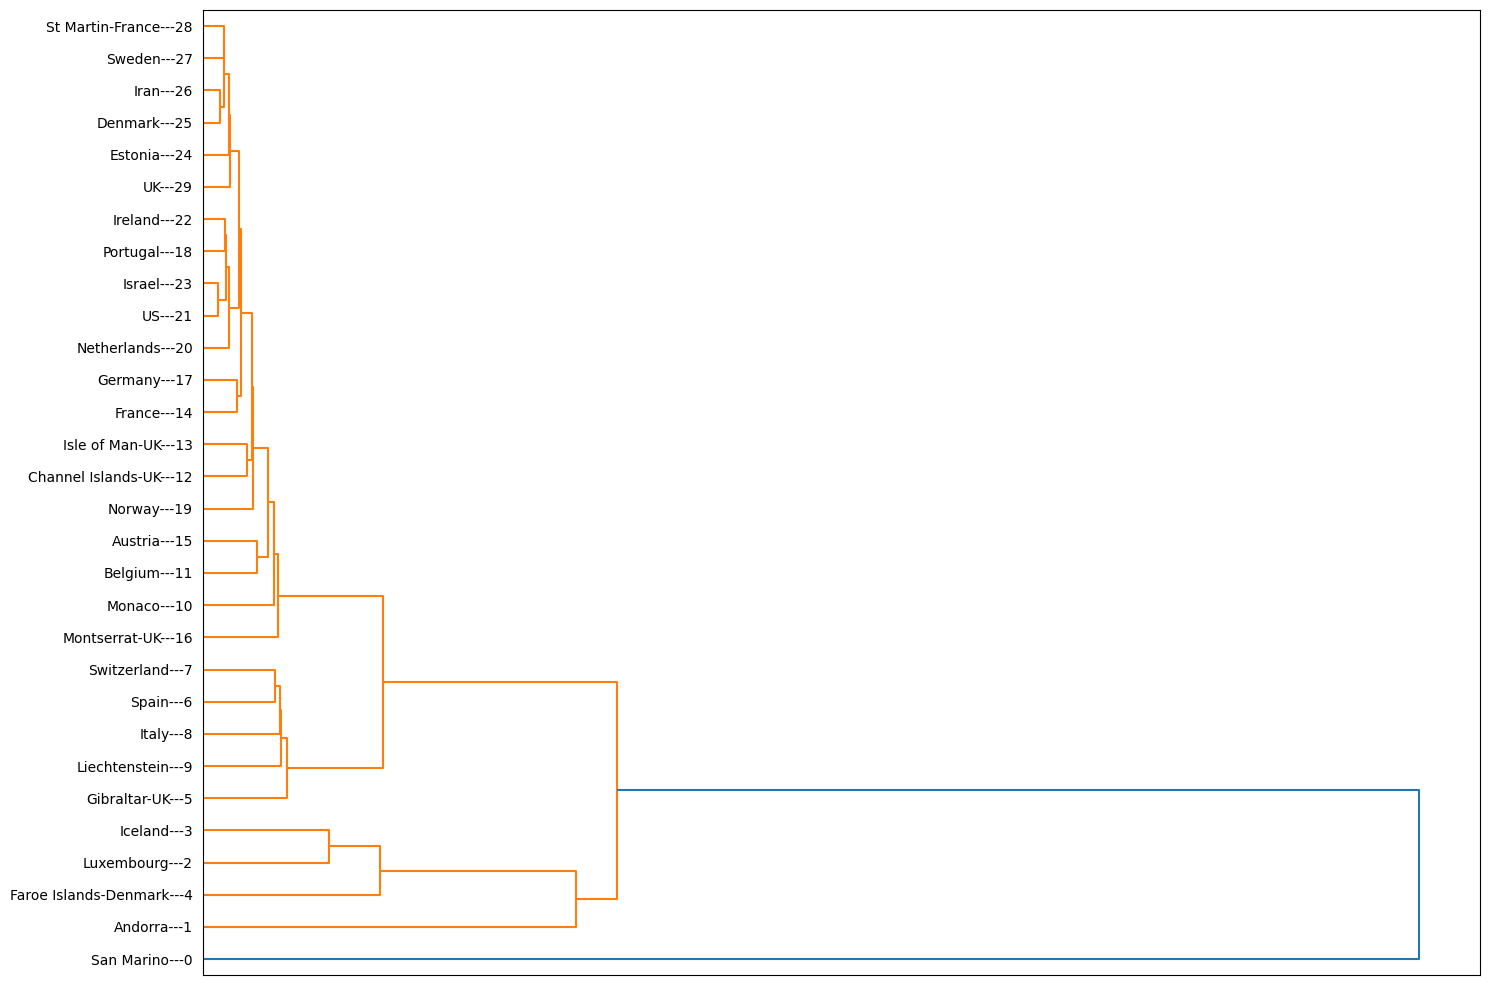

In [148]:
fig, axes = plt.subplots(figsize=(15, 10))

plot_hierarchy(data_2date_trunc, ax=axes)

fig.tight_layout()

plt.savefig('../figures/Clustering2')

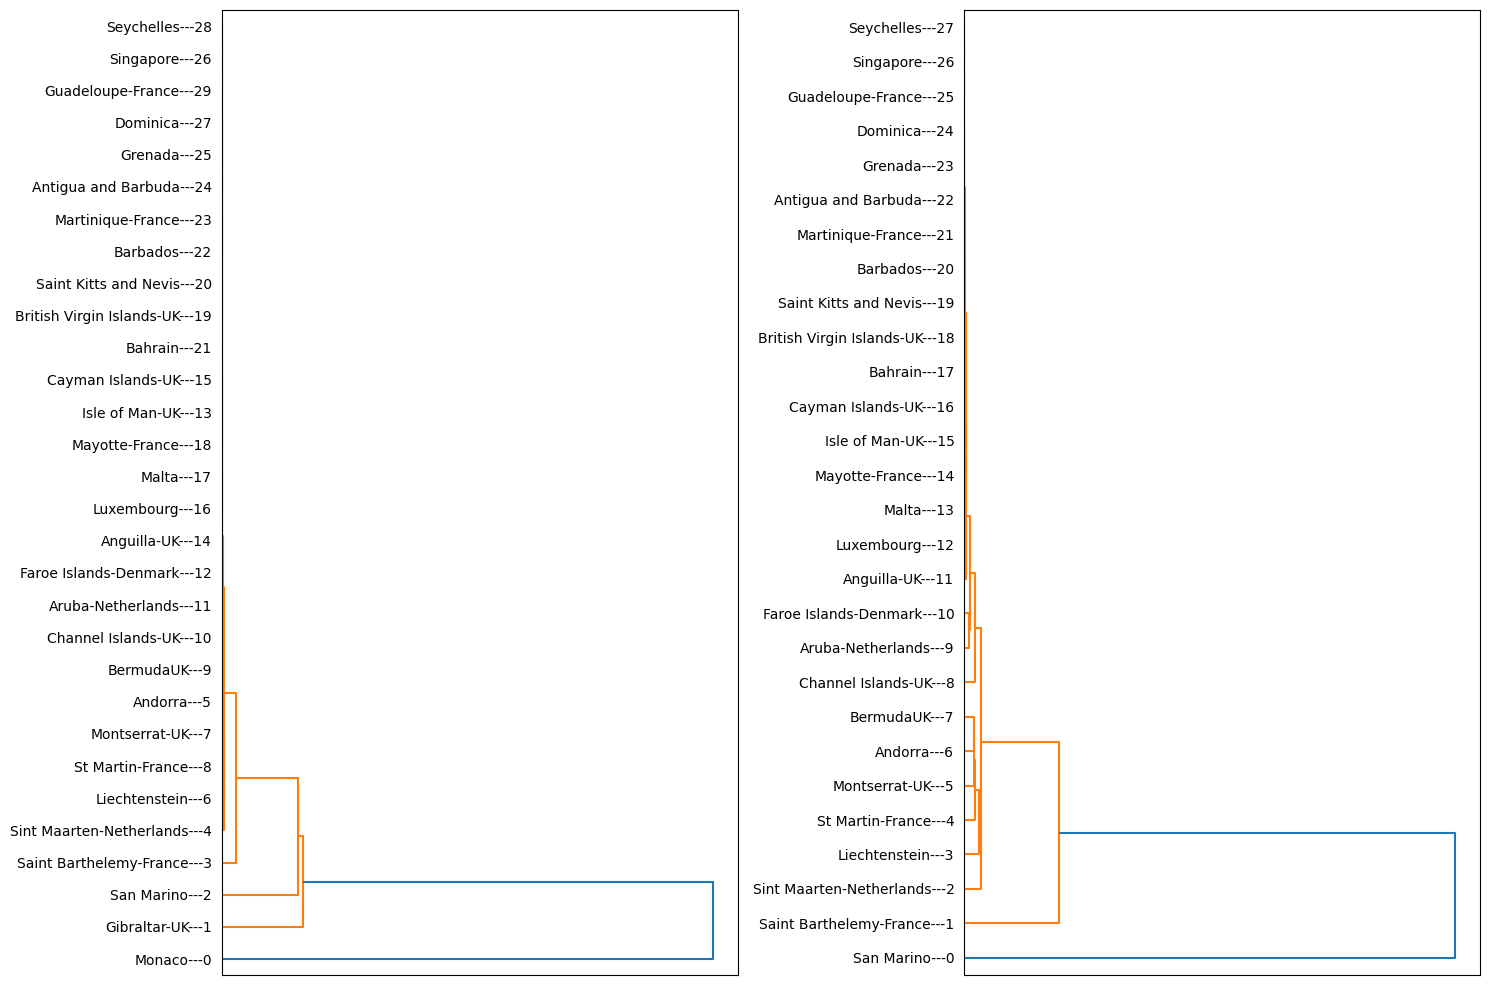

In [149]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

dend5 = plot_hierarchy(data_5date_trunc, ax=axes[0])
plot_hierarchy(data_5date_trunc.iloc[:, dend5['leaves'][2:]], ax=axes[1])

fig.tight_layout()

plt.savefig('../figures/Clustering5')

# World map

In [287]:
data_world = data_1date_trunc[:44].T.copy()
matrix = linkage(data_world, method='single', metric='euclidean')
cluster_assignment = fcluster(matrix, 5, criterion='maxclust')
clusters = pd.DataFrame(cluster_assignment, index=data_world.index)
temp = pd.DataFrame([0] * len(data_1date.columns), index=data_1date.columns, columns=['clusters'])
temp.loc[clusters.index] = clusters 
clusters = temp.copy()

In [288]:
codes = []
for country in clusters.index:
    try:
        codes.append(countrynames.to_code_3(country))
    except:
        try: 
            codes.append(pycountry.countries.get(name=country).alpha_3)
        except: 
            codes.append(country)
codes = pd.DataFrame(codes, index=clusters.index, columns=['CODE'])
data_world_clusters = clusters.join(codes)


In [278]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='covid_data')
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

location_list = []
for country in codes.iloc[:, 0]:
    location_list.append(geolocate(country))

In [289]:
location_data = pd.DataFrame(location_list, index=data_world_clusters.index, columns=['latitude', 'longitude']) 
data_world_location = data_world_clusters.copy().join(location_data)

In [290]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge = pd.merge(world, data_world_location, on='CODE')

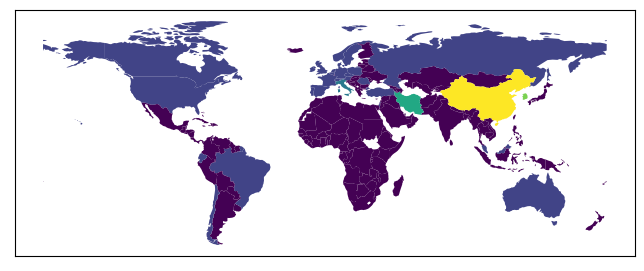

In [293]:
fig, axes = plt.subplots(figsize=(8, 6))
merge.plot(column='clusters', ax=axes)
axes.grid(False)

axes.set_xticks([])
axes.set_yticks([]);